In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN 5005)


In [2]:
resized_data = 'resized_data/'

In [3]:
f_names = [x[2] for x in os.walk(resized_data)]

In [4]:
u_labels = []
for name in f_names[0]:
    u_labels.append(name[:-4])

In [5]:
print len(u_labels), len(f_names[0])

43 43


In [6]:
data = []
labels = []
for ix in range(len(u_labels)):
    a = np.load(resized_data + u_labels[ix] + '.npy')
    labels += [u_labels[ix]] * a.shape[0]
    data.extend(a)
print len(data), len(labels)
data = np.array(data)
labels = np.array(labels)

39209 39209


In [7]:
data.shape, labels.shape

((39209, 32, 32), (39209,))

In [8]:
cat_labels = np_utils.to_categorical(labels, nb_classes=43)
# y_test = np_utils.to_categorical(y_test)
cat_labels.shape


/home/laksh/ml/local/lib/python2.7/site-packages/keras/utils/np_utils.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


(39209, 43)

In [9]:
num_op = cat_labels.shape[1]

In [10]:
print labels[15000], np.unique(cat_labels[15000], return_index=True)

00006 (array([ 0.,  1.]), array([0, 6]))


In [11]:
data.shape[0]

39209

In [12]:
idx = np.random.permutation(data.shape[0])
data,cat_labels = data[idx], cat_labels[idx]

In [13]:
data.shape, cat_labels.shape

((39209, 32, 32), (39209, 43))

(array([ 0.,  1.]), array([ 0, 38]))


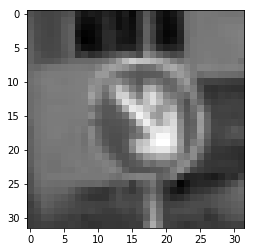

In [14]:
l = 47
plt.imshow(data[l],cmap='gray')
xd = np.unique(cat_labels[l],return_index=True)
print xd

In [15]:
split = int(0.75 * data.shape[0])
x_train = data[:split]
y_train = cat_labels[:split]
x_test = data[split:]
y_test = cat_labels[split:]
print x_train.shape, x_test.shape
print y_train.shape, y_test.shape

(29406, 32, 32) (9803, 32, 32)
(29406, 43) (9803, 43)


In [16]:
x_train = x_train.reshape(x_train.shape[0],1, x_train.shape[1], x_train.shape[2]).astype('float32')
x_test = x_test.reshape(x_test.shape[0],1, x_test.shape[1], x_train.shape[2]).astype('float32')

In [17]:
print x_train.shape, x_test.shape

(29406, 1, 32, 32) (9803, 1, 32, 32)


In [20]:
def cnn_model2():
    model = Sequential()

    model.add(Convolution2D(128, 3, 3, border_mode='same', input_shape=(1, 32, 32), activation='relu'))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_op, activation='softmax'))
    return model

In [21]:
model = cnn_model2()
model.summary()

/home/laksh/ml/local/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/laksh/ml/local/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/laksh/ml/local/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 128, 32, 32)   1280        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 128, 30, 30)   147584      convolution2d_3[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 128, 15, 15)   0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 128, 15, 15)   0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [22]:
from keras.optimizers import SGD

# let's train the model using SGD + momentum
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
optimizer=sgd,
metrics=['accuracy'])

In [23]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), nb_epoch=10, batch_size=128)

Train on 29406 samples, validate on 9803 samples
Epoch 1/10
29406/29406 [==============================] - 147s - loss: 3.5546 - acc: 0.0730 - val_loss: 3.1063 - val_acc: 0.2263
Epoch 2/10
29406/29406 [==============================] - 110s - loss: 2.2051 - acc: 0.4139 - val_loss: 0.9298 - val_acc: 0.7547
Epoch 3/10
29406/29406 [==============================] - 52s - loss: 1.1304 - acc: 0.6872 - val_loss: 0.4878 - val_acc: 0.8774
Epoch 4/10
29406/29406 [==============================] - 52s - loss: 0.7272 - acc: 0.7989 - val_loss: 0.3318 - val_acc: 0.9197
Epoch 5/10
29406/29406 [==============================] - 55s - loss: 0.5878 - acc: 0.8434 - val_loss: 0.2070 - val_acc: 0.9524
Epoch 6/10
29406/29406 [==============================] - 55s - loss: 0.4696 - acc: 0.8776 - val_loss: 0.1533 - val_acc: 0.9627
Epoch 7/10
29406/29406 [==============================] - 56s - loss: 0.3912 - acc: 0.9020 - val_loss: 0.1503 - val_acc: 0.9661
Epoch 8/10
29406/29406 [=============================

In [18]:
def cnn_model():
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(1, 32, 32), activation='relu'))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_op, activation='softmax'))
    return model

In [20]:
model = cnn_model()
model.summary()

/home/laksh/ml/local/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/laksh/ml/local/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/laksh/ml/local/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 30, 30)    9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 15, 15)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 15, 15)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [22]:
from keras.optimizers import SGD

# let's train the model using SGD + momentum
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
optimizer=sgd,
metrics=['accuracy'])

In [23]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), nb_epoch=10, batch_size=128)

Train on 29406 samples, validate on 9803 samples
Epoch 1/10
29406/29406 [==============================] - 15s - loss: 3.0918 - acc: 0.2022 - val_loss: 1.6986 - val_acc: 0.5764
Epoch 2/10
29406/29406 [==============================] - 16s - loss: 1.1346 - acc: 0.6912 - val_loss: 0.3422 - val_acc: 0.9222
Epoch 3/10
29406/29406 [==============================] - 23s - loss: 0.5216 - acc: 0.8579 - val_loss: 0.1788 - val_acc: 0.9519
Epoch 4/10
29406/29406 [==============================] - 24s - loss: 0.3605 - acc: 0.9015 - val_loss: 0.1213 - val_acc: 0.9711
Epoch 5/10
29406/29406 [==============================] - 23s - loss: 0.2739 - acc: 0.9286 - val_loss: 0.0780 - val_acc: 0.9804
Epoch 6/10
29406/29406 [==============================] - 23s - loss: 0.2307 - acc: 0.9396 - val_loss: 0.1137 - val_acc: 0.9715
Epoch 7/10
29406/29406 [==============================] - 24s - loss: 0.2053 - acc: 0.9452 - val_loss: 0.0750 - val_acc: 0.9811
Epoch 8/10
29406/29406 [==============================]